Requires notebook 0.

In [1]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dataorganizer)
  library(ggplot2)
  library(ggrastr)
  library(data.table)
  library(readr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [2]:
# load spatial metadata
meta_total_sub <- prepare_nsclc_metadata(reps='one')

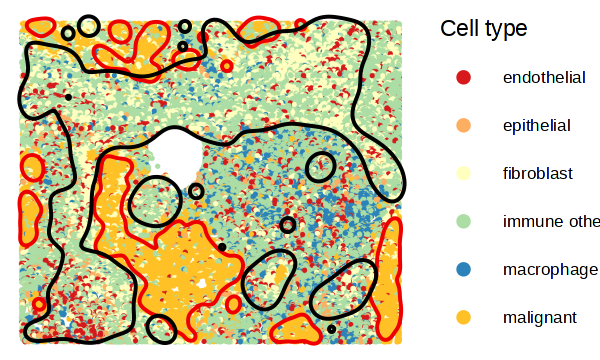

In [3]:
options(repr.plot.width = 3, repr.plot.height = 1.8, repr.plot.res = 200)

### plotting the nsclc data and highlighting spatially distinct regions
### clustering the different tumor interior regions
meta_total_sub_tumor <- meta_total_sub[meta_total_sub$niche=='tumor interior',]
dist_mat <- dist(meta_total_sub_tumor[,c('x','y')], method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'single')
cut_avg <- cutree(hclust_avg, k = 15)
meta_total_sub_tumor$t_clust <- cut_avg
meta_total_sub$t_clust <- NA
meta_total_sub[rownames(meta_total_sub_tumor),'t_clust'] <- meta_total_sub_tumor$t_clust

meta_total_sub_tumor$t_clust <- as.factor(meta_total_sub_tumor$t_clust)
meta_total_sub$t_clust <- as.factor(meta_total_sub$t_clust)

myColors <- RColorBrewer::brewer.pal(5, 'Spectral')
myColors <- c(myColors,'goldenrod1')
p <- ggplot(meta_total_sub,aes(x=x,y=y,color=cell_type_coarse)) +
  geom_point_rast(size=.001) +
  # scale_color_brewer(palette = "Spectral") +
  scale_colour_manual(values = myColors) +
  guides(colour = guide_legend(override.aes = list(size=3)))

conf="5%"
t_unq <- as.numeric(unique(meta_total_sub_tumor$t_clust))
for (i in t_unq) {
  emb <- meta_total_sub_tumor[meta_total_sub_tumor$t_clust==i,]
  emb <- emb[,c('x','y')]

  # kd <- ks::kde(emb, compute.cont=TRUE,binned = TRUE)
  h <- matrix(c(.005, 0, 0, .005), ncol=2)
  kd <- ks::kde(emb, compute.cont=TRUE, H=h)
  lcn <- kd %$% contourLines(x=eval.points[[1]], y=eval.points[[2]], z=estimate, levels=cont[conf]) %>%
    .[[1]] %>% data.frame() %>% cbind(z=1)
  cn <- geom_path(aes(x, y), data=lcn, color='red2')

  p <- p + cn
}

### now clustering the different stroma regions
meta_total_sub_stroma <- meta_total_sub[meta_total_sub$niche=='stroma',]
dist_mat <- dist(meta_total_sub_stroma[,c('x','y')], method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'single')
cut_avg <- cutree(hclust_avg, k = 15)
meta_total_sub_stroma$s_clust <- cut_avg
meta_total_sub$s_clust <- NA
meta_total_sub[rownames(meta_total_sub_stroma),'s_clust'] <- meta_total_sub_stroma$s_clust

meta_total_sub_stroma$s_clust <- as.factor(meta_total_sub_stroma$s_clust)
meta_total_sub$s_clust <- as.factor(meta_total_sub$s_clust)


s_unq <- as.numeric(unique(meta_total_sub_stroma$s_clust))
conf="5%"
for (i in s_unq) {
  emb <- meta_total_sub_stroma[meta_total_sub_stroma$s_clust==i,]
  emb <- emb[,c('x','y')]

  h <- matrix(c(.025, 0, 0, .025), ncol=2)
  kd <- ks::kde(emb, compute.cont=TRUE, H=h)
  lcn <- kd %$% contourLines(x=eval.points[[1]], y=eval.points[[2]], z=estimate, levels=cont[conf]) %>%
    .[[1]] %>% data.frame() %>% cbind(z=1)
  cn <- geom_path(aes(x, y), data=lcn, color='black')

  p <- p + cn
}


p <- p +
  labs(color='Cell type') +
  theme_void() +
  legend_mod +
  theme(text = element_text(family = font_choice),
        legend.text=element_text(size=6),
        legend.title=element_text(size=8))

p

In [4]:
# getting height width ratio to keep aspect ratio accurate in the pdf
x_diff <- max(meta_total_sub$x) - min(meta_total_sub$x)
y_diff <- max(meta_total_sub$y) - min(meta_total_sub$y)
aspect_ratio <- y_diff / x_diff

width_plot <- 2.25
height_plot <- aspect_ratio * width_plot
print(height_plot)

[1] 1.800551


In [5]:
# saving a version without the legend, which has the correct proportions
pdf(OutputPath("nsclc_tumor_regions.pdf"), useDingbats=FALSE, width=width_plot, height=height_plot)
p + theme(legend.position="none")
dev.off()

png 
  2

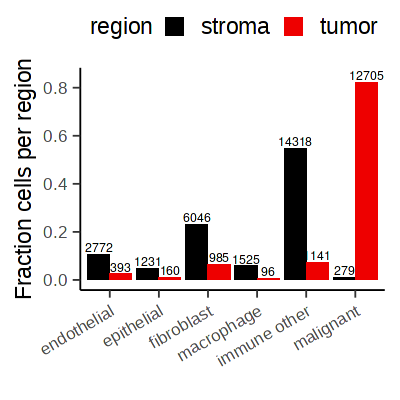

In [6]:
# options(repr.plot.width = 2.75, repr.plot.height = 1, repr.plot.res = 200)
options(repr.plot.width = 2, repr.plot.height = 2, repr.plot.res = 200)

## compute counts of each cell type in each region
meta_total_sub_stroma <- meta_total_sub[meta_total_sub$niche=='stroma',]
ct_counts_stroma <- table(meta_total_sub_stroma$cell_type_coarse)
meta_total_sub_tumor <- meta_total_sub[meta_total_sub$niche=='tumor interior',]
ct_counts_tumor <- table(meta_total_sub_tumor$cell_type_coarse)
c1 <- c(ct_counts_stroma,ct_counts_tumor)
c2 <- c(names(ct_counts_stroma),names(ct_counts_tumor))
c3 <- c(rep('stroma',length(ct_counts_stroma)),rep('tumor interior',length(ct_counts_tumor)))
ct_fracs <- cbind.data.frame(c1,c2,c3)
colnames(ct_fracs) <- c('counts','cell_type','region')
ct_fracs$cell_type <- factor(ct_fracs$cell_type,levels=c('endothelial','epithelial','fibroblast','macrophage','immune other','malignant'))
ct_fracs$region <- factor(ct_fracs$region,levels=c('stroma','tumor interior'))
ct_fracs2 <- ct_fracs

total_counts <- table(meta_total_sub$niche)
match_ndx <- match(ct_fracs2$region,names(total_counts))
ct_fracs2$total_counts <- total_counts[match_ndx]
ct_fracs2$fracs <- ct_fracs2$counts / ct_fracs2$total_counts

ct_fracs2$region <- factor(ct_fracs2$region,levels=c('stroma','tumor interior'))
levels(ct_fracs2$region) <- c(c('stroma','tumor'))
p <- ggplot(ct_fracs2,aes(x=cell_type,y=fracs,fill=region)) +
  geom_bar(position = "dodge", stat = "identity") +
  geom_text(aes(label=counts), position=position_dodge(width=0.9), vjust=-0.25, size=(3*geom_text_size)/4) +
  ylim(c(0,max(ct_fracs2$fracs)+.02)) +
  xlab('') +
  ylab('Fraction cells per region') +
  theme_classic(base_line_size = gg_line_thickness) +
  scale_fill_manual(breaks = c('stroma','tumor'),values = c('black','red2')) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
       legend.key.size = unit(8, 'pt'),
        legend.key.height = unit(8, 'pt'),
        legend.key.width = unit(8, 'pt'),
        legend.title=element_text(size=8),
        legend.text=element_text(size=8),
       axis.title.x = element_text(size = 5),
       legend.position="top",
       legend.box="vertical", legend.margin=margin())


p

In [7]:
pdf(OutputPath("nsclc_cell_counts.pdf"), useDingbats=FALSE, width=2, height=2)
p
dev.off()

png 
  2

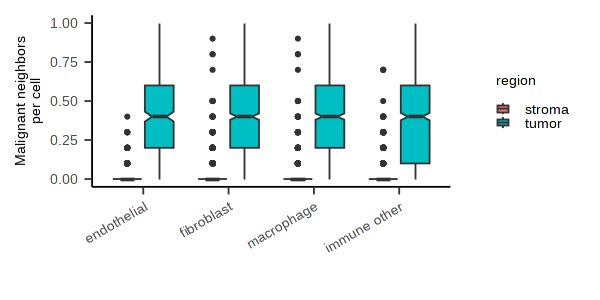

In [8]:
options(repr.plot.width = 3, repr.plot.height = 1.5, repr.plot.res = 200)

## now computing average malignant adjacencies per cell
stroma_knn = meta_total_sub_stroma %>% select(x, y) %>% FNN::get.knn(k = 10) %>% .$nn.index
rownames(stroma_knn) <- rownames(meta_total_sub_stroma)
tumor_knn = meta_total_sub_tumor %>% select(x, y) %>% FNN::get.knn(k = 10) %>% .$nn.index
rownames(tumor_knn) <- rownames(meta_total_sub_tumor)

get_mal_adj <- function(ctype,metadat,metaknn) {
  metadat_cells <- rownames(metadat)[metadat$cell_type_coarse==ctype]
  fracs_mal <- sapply(metadat_cells,function(mycell) {
    nearest_cells <- metaknn[mycell,]
    return(sum(metadat[nearest_cells,'cell_type_coarse']=='malignant')/10)
  })
  return(fracs_mal)
}


endo_strom <- get_mal_adj('endothelial',meta_total_sub_stroma,stroma_knn)
endo_tum <- get_mal_adj('endothelial',meta_total_sub_tumor,tumor_knn)
fib_strom <- get_mal_adj('fibroblast',meta_total_sub_stroma,stroma_knn)
fib_tum <- get_mal_adj('fibroblast',meta_total_sub_tumor,tumor_knn)
macro_strom <- get_mal_adj('macrophage',meta_total_sub_stroma,stroma_knn)
macro_tum <- get_mal_adj('macrophage',meta_total_sub_tumor,tumor_knn)
imm_strom <- get_mal_adj('immune other',meta_total_sub_stroma,stroma_knn)
imm_tum <- get_mal_adj('immune other',meta_total_sub_tumor,tumor_knn)

m1 <- cbind.data.frame(endo_strom,'endothelial','stroma')
m2 <- cbind.data.frame(endo_tum,'endothelial','tumor')
m3 <- cbind.data.frame(fib_strom,'fibroblast','stroma')
m4 <- cbind.data.frame(fib_tum,'fibroblast','tumor')
m5 <- cbind.data.frame(fib_strom,'macrophage','stroma')
m6 <- cbind.data.frame(fib_tum,'macrophage','tumor')
m7 <- cbind.data.frame(imm_strom,'immune other','stroma')
m8 <- cbind.data.frame(imm_tum,'immune other','tumor')

colnames(m1) <- colnames(m2) <- colnames(m3) <- colnames(m4) <- colnames(m5) <- colnames(m6) <- colnames(m7) <- colnames(m8) <- c('frac','ct','region')
rownames(m1) <- rownames(m2) <- rownames(m3) <- rownames(m4) <- rownames(m5) <- rownames(m6) <- rownames(m7) <- rownames(m8) <- NULL

adj_fracs <- rbind.data.frame(m1,m2,m3,m4,m5,m6,m7,m8)

adj_fracs$ct <- factor(adj_fracs$ct,levels=c('endothelial','fibroblast','macrophage','immune other'))
adj_fracs$region <- as.factor(adj_fracs$region)

p <- ggplot(adj_fracs,aes(x=ct,y=frac,fill=region)) +
  geom_boxplot(notch=TRUE,outlier.size = gg_point_size/8,linewidth = gg_line_thickness) +
  ylab('Malignant neighbors\nper cell') +
  xlab('') +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1,size=5),
        axis.text.y = element_text(size=5),
        axis.title.y = element_text(size=5),
        legend.key.size = unit(5, 'pt'),
        legend.key.height = unit(5, 'pt'),
        legend.key.width = unit(5, 'pt'),
        legend.title=element_text(size=5),
        legend.text=element_text(size=5))


p

In [9]:
pdf(OutputPath("nsclc_cell_adj_freq.pdf"), useDingbats=FALSE, width=2.75, height=1)
p
dev.off()

png 
  2